In [1]:
import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import time
import timeit

In [2]:
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress = True)

In [3]:
df = pd.read_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED.csv")

In [4]:
# Drop the extra index column created when the data is loaded
df.drop(df.columns[0], axis=1, inplace=True)

# SAVE SOME GLOBAL VARIABLES
DF_COL_NAMES = df.columns

FIPS_STATE = df['FIPS_STATE_CODE']
FIPS_COUNTY = df['FIPS_COUNTY_CODE']
FIPS = df['FIPS']
STATE = df["STATE"]
COUNTY = df["COUNTY"]

df.drop(["STATE", "COUNTY", "FIPS", "CBSA"], axis=1, inplace=True)

df.head()

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,HO_RANK,HO_PROP_RANK,HO_QUARTILE,HF_RANK,HF_PROP_RANK,HF_QUARTILE,HF_HIGH,HIGH_SEV,HIGH_PROCS,DIVERSE_PROP
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,23.0,0.657,2.0,10.0,0.851,1.0,1.0,0.0,1.0,0.312500
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,3.0,0.955,1.0,3.0,0.955,1.0,1.0,1.0,1.0,0.368421
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,45.0,0.328,3.0,54.0,0.194,4.0,0.0,1.0,0.0,0.500000
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,51.0,0.239,4.0,19.0,0.716,2.0,1.0,1.0,1.0,0.294118
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,10.0,0.851,1.0,9.0,0.866,1.0,1.0,0.0,0.0,0.409091


## Principal Component Analysis

In [5]:
# Drop NaNs because PCA and other dimension reduction calculations can't run on NaNs.
df = df.dropna()

# Subset the dataframe to variables for cluster analysis
X = df[["CNTY_MEAN_AGE", "CNTY_SEX_PROP", "DIVERSE_PROP", "CODES_PU", "PROCS_PU", "PRVDRS_PU",
         "TOT_IPDAYS_PU", "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "HF_PROP_RANK", 
          "CNTY_USR_PROP", "CNTY_IP_PROP"]]

y1 = df["TOT_COST_PB"]
y2 = df["TOT_VSTS_PB"]


X.shape

(2749, 13)

In [6]:
from sklearn.decomposition import PCA

start_time = time.time()

# Run PCA, obtaining enough components to describe 80% of the variation in the selected data.
pca = PCA(n_components = 0.95)

X_reduced_PCA = pca.fit_transform(X)
end_time = time.time()

features_PC_inv = pca.inverse_transform(X_reduced_PCA)

print("Total run time = %.3f seconds" %(end_time - start_time))
features_PC_inv

Total run time = 0.027 seconds


array([[65.417,  0.469,  0.184, ...,  0.494,  0.761,  0.083],
       [70.285,  0.451,  0.167, ...,  0.5  ,  0.761,  0.085],
       [72.394,  0.449,  0.146, ...,  0.493,  0.751,  0.095],
       ...,
       [70.476,  0.462,  0.145, ...,  0.491,  0.724,  0.053],
       [71.961,  0.463,  0.144, ...,  0.49 ,  0.767,  0.058],
       [75.469,  0.455,  0.105, ...,  0.479,  0.709,  0.075]])

In [7]:
# The first component explains 47% of the variance, second 33% and third 14%.
# After that, the components' explanatory power drops off a great deal.

pca.explained_variance_ratio_

array([0.473, 0.332, 0.14 , 0.026])

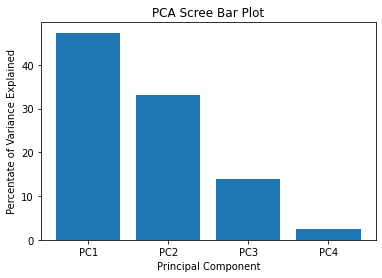

In [8]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1', 'PC2', 'PC3', 'PC4']
plt.bar(x= range(1,5), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Bar Plot')
plt.show()

In [9]:
# We center the data and compute the sample covariance matrix.
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / 2749
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)

30.897165093670537
30.90840860352994
21.636347184593937
21.64422067338015
9.107184173760228
9.110498287360581
1.677226109543156
1.6778364538333788


## Kernel PCA

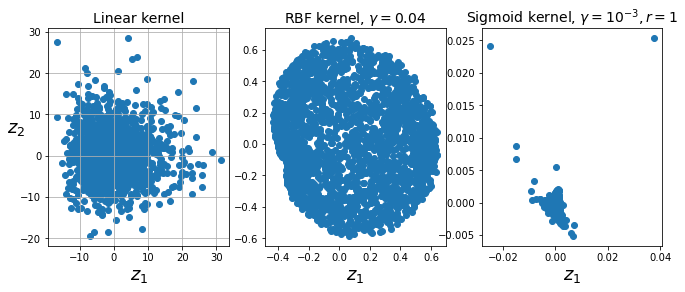

In [10]:
# Kernel PCA 
from sklearn.decomposition import KernelPCA
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)
plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):    
    X_reduced = pca.fit_transform(X)    
    if subplot == 132:        
        X_reduced_rbf = X_reduced
    plt.subplot(subplot)    
    plt.title(title, fontsize=14)    
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1],  cmap=plt.cm.hot)    
    plt.xlabel("$z_1$", fontsize=18)    
    if subplot == 131:        
        plt.ylabel("$z_2$", fontsize=18, rotation=0)    
        plt.grid(True)
plt.show()

The RBF Type Kernel is doing the best job at clustering the data.

In [11]:
X_reduced_KPCA = rbf_pca.fit_transform(X)

In [12]:
X_reduced_KPCA.shape

(2749, 2)

## Local Linear Embedding (LLE)

In [13]:
start_time = time.time()
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=3, n_neighbors=10)
X_reduced_LLE = lle.fit_transform(X)
print(X_reduced_LLE)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

[[ 0.006  0.008 -0.002]
 [-0.001  0.003 -0.006]
 [ 0.001  0.002  0.001]
 ...
 [-0.     0.009 -0.007]
 [ 0.003  0.001 -0.   ]
 [ 0.006  0.013  0.033]]
Total run time = 1.103 seconds


## ISOMap

In [14]:
start_time = time.time()
from sklearn.manifold import Isomap
isomap = Isomap(n_components=3)
X_reduced_isomap = isomap.fit_transform(X)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

Total run time = 3.276 seconds


In [15]:
X_reduced_isomap

array([[ -2.528,  11.464,   0.282],
       [  4.714,   4.527,  -0.198],
       [ -2.762,   0.796,   0.891],
       ...,
       [-11.198,   1.977,  -1.749],
       [ -8.913,   0.226,  -2.039],
       [-22.482,  -6.983,  -1.816]])

## tSNE

In [16]:
start_time = time.time()
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, random_state=123)
X_reduced_tsne = tsne.fit_transform(X)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

Total run time = 24.973 seconds


In [17]:
X_reduced_tsne

array([[-3.924, -6.579,  1.053],
       [-5.883, -1.268, -2.064],
       [ 3.692, -1.304, -1.63 ],
       ...,
       [ 5.308, -7.872,  3.828],
       [ 7.542, -6.544,  1.139],
       [ 6.765, -2.05 , 10.273]], dtype=float32)

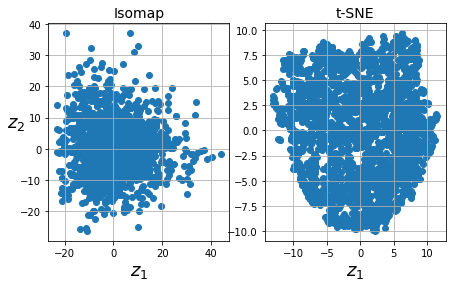

In [18]:
titles = ["Isomap", "t-SNE"]

plt.figure(figsize=(11,4))
for subplot, title, X_reduced in zip((131, 132), titles, (X_reduced_isomap, X_reduced_tsne)):    
    plt.subplot(subplot)    
    plt.title(title, fontsize=14)    
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], cmap=plt.cm.hot)    
    plt.xlabel("$z_1$", fontsize=18)    
    if subplot == 131:        
        plt.ylabel("$z_2$", fontsize=18, rotation=0)    
    plt.grid(True)

plt.show()

## UMAP

In [19]:
# NOTE: The package to install is NOT umap; it is umap-learn
import umap.umap_ as umap

In [20]:
start_time = time.time()
reducer = umap.UMAP()
X_reduced_UMAP = reducer.fit_transform(X)
end_time = time.time()
print("Total run time = %.3f seconds" %(end_time - start_time))

Total run time = 12.068 seconds


In [21]:
X_reduced_UMAP.shape

(2749, 2)

In [22]:
X_reduced_UMAP

array([[6.531, 2.656],
       [8.458, 4.694],
       [4.232, 6.302],
       ...,
       [1.777, 4.925],
       [2.594, 5.535],
       [0.34 , 8.146]], dtype=float32)

In [23]:
PCA = pd.DataFrame(X_reduced_PCA, columns =["PCA_1", "PCA_2", "PCA_3", "PCA_4"])
KPCA = pd.DataFrame(X_reduced_KPCA, columns =["KPCA_1", "KPCA_2"])
UMAP = pd.DataFrame(X_reduced_UMAP, columns =["UMAP_1", "UMAP_2"])
tsne = pd.DataFrame(X_reduced_tsne, columns = ["tSNE_1", "tSNE_2", "tSNE_3"])
LLE = pd.DataFrame(X_reduced_LLE, columns = ["LLE_1", "LLE_2", "LLE_3"])
isomap = pd.DataFrame(X_reduced_isomap, columns = ["ISO_1", "ISO_2", "ISO_3"])


In [24]:
df.shape

(2749, 64)

In [25]:
df.iloc[:, 0:64]

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,HO_RANK,HO_PROP_RANK,HO_QUARTILE,HF_RANK,HF_PROP_RANK,HF_QUARTILE,HF_HIGH,HIGH_SEV,HIGH_PROCS,DIVERSE_PROP
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,23.0,0.657,2.0,10.0,0.851,1.0,1.0,0.0,1.0,0.312500
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,3.0,0.955,1.0,3.0,0.955,1.0,1.0,1.0,1.0,0.368421
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,45.0,0.328,3.0,54.0,0.194,4.0,0.0,1.0,0.0,0.500000
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,51.0,0.239,4.0,19.0,0.716,2.0,1.0,1.0,1.0,0.294118
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,10.0,0.851,1.0,9.0,0.866,1.0,1.0,0.0,0.0,0.409091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,56.0,33.0,42,20,68.5,0.619048,2.0,4.0,6.0,154,...,16.0,0.304,3.0,11.0,0.522,2.0,0.0,0.0,0.0,0.000000
2942,56.0,37.0,34,17,72.9,0.529412,8.0,3.0,4.0,138,...,20.0,0.130,4.0,21.0,0.087,4.0,0.0,0.0,1.0,0.000000
2943,56.0,39.0,13,5,70.5,0.538462,3.0,2.0,1.0,38,...,1.0,0.957,1.0,1.0,0.957,1.0,1.0,0.0,0.0,0.000000
2944,56.0,41.0,18,6,72.0,0.500000,2.0,1.0,0.0,61,...,22.0,0.043,4.0,13.0,0.435,3.0,0.0,0.0,0.0,0.055556


In [26]:
all_reducers = [PCA, KPCA, UMAP, tsne, LLE, isomap]
names = ["PCA", "KPCA", "UMAP", "TSNE", "LLE", "ISO"]

merge_reducers = df.iloc[:,0:64]
for d in all_reducers:
    merge_reducers = merge_reducers.merge(d, left_index=True, right_index=True)

In [27]:
merge_reducers

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,UMAP_2,tSNE_1,tSNE_2,tSNE_3,LLE_1,LLE_2,LLE_3,ISO_1,ISO_2,ISO_3
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,2.655914,-3.923615,-6.579272,1.053338,0.006143,0.008322,-0.001794,-2.527767,11.463513,0.281508
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,4.694168,-5.882513,-1.268123,-2.063540,-0.000982,0.003482,-0.006171,4.713958,4.526721,-0.198007
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,6.302010,3.691803,-1.303633,-1.630488,0.000700,0.002442,0.001385,-2.762451,0.795579,0.891461
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,4.071944,-6.548240,-3.598887,-2.922598,-0.002434,-0.001071,-0.005839,4.518402,6.468064,-1.218609
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,3.606805,0.294353,-5.052079,2.082623,-0.000410,0.003534,-0.004396,-5.030677,5.879840,3.685055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744,51.0,680.0,36,33,70.9,0.444444,8.0,4.0,6.0,329,...,3.259608,1.927198,-9.523649,0.655482,-0.001193,0.005766,-0.009353,-7.084755,6.197747,-2.354903
2745,51.0,683.0,22,16,74.8,0.636364,4.0,3.0,3.0,131,...,5.888075,5.548365,-2.133241,-5.462046,-0.002985,-0.002722,-0.007061,-1.427608,0.855833,-2.711596
2746,51.0,690.0,21,18,73.1,0.571429,3.0,0.0,4.0,116,...,4.924926,5.307599,-7.871549,3.827837,-0.000263,0.008684,-0.007164,-11.198213,1.977130,-1.749427
2747,51.0,700.0,68,55,72.2,0.426471,10.0,5.0,14.0,625,...,5.534780,7.542196,-6.544301,1.138883,0.002608,0.001434,-0.000040,-8.913427,0.226404,-2.038549


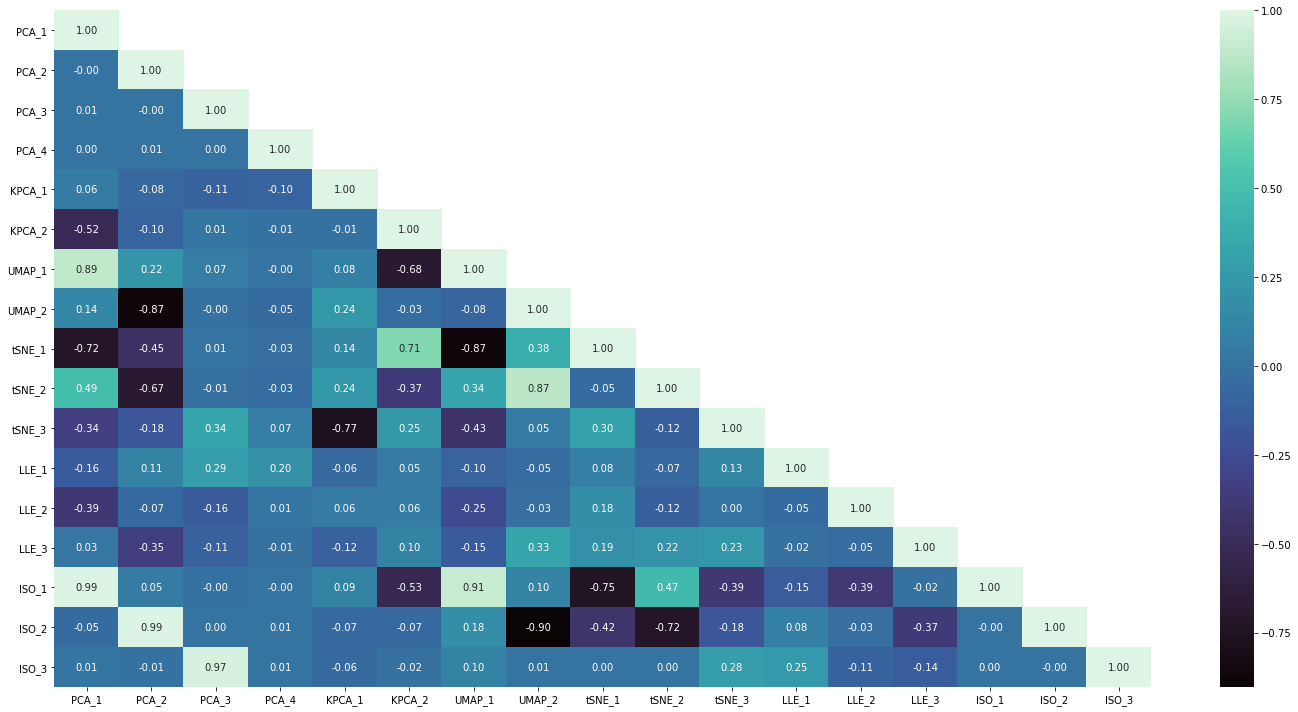

In [28]:
corr_embeddings = merge_reducers.iloc[:, 64:].corr()
lower_corr = corr_embeddings.where(np.tril(np.ones(corr_embeddings.shape)).astype(np.bool))

plt.rcParams["figure.figsize"] = (20.0, 10.0)
corr_hmap=sb.heatmap(lower_corr, annot=True, cmap="mako", fmt=".2f")
fig = corr_hmap.get_figure()
fig.tight_layout()
fig.savefig("embeddings_heatmap.png")

## Reducer Correlations

PCA1 and UMAP1 are highly correlated.

PCA1 and ISO1 are also highly correlated.

OTHERS:

PCA2 and ISO2

PCA3 and ISO3

TSNE1 and KPCA2

ISO1 and UMAP1

TSNE2 and UMAP2


In [29]:
merge_reducers.shape

(2563, 81)

In [30]:
merge_reducers.head()

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,UMAP_2,tSNE_1,tSNE_2,tSNE_3,LLE_1,LLE_2,LLE_3,ISO_1,ISO_2,ISO_3
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,2.655914,-3.923615,-6.579272,1.053338,0.006143,0.008322,-0.001794,-2.527767,11.463513,0.281508
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,4.694168,-5.882513,-1.268123,-2.063540,-0.000982,0.003482,-0.006171,4.713958,4.526721,-0.198007
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,6.302010,3.691803,-1.303633,-1.630488,0.000700,0.002442,0.001385,-2.762451,0.795579,0.891461
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,4.071944,-6.548240,-3.598887,-2.922598,-0.002434,-0.001071,-0.005839,4.518402,6.468064,-1.218609
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,3.606805,0.294353,-5.052079,2.082623,-0.000410,0.003534,-0.004396,-5.030677,5.879840,3.685055


In [31]:
# Try kMeans clustering on each group of reducers
from sklearn.cluster import KMeans
k = 5

clusterdf = pd.DataFrame()
for i,j in enumerate(all_reducers):
    kmeans = KMeans(n_clusters=k)
    names[i] = kmeans.fit_predict(j)
    clusterdf[i] = names[i]


# Gving column names to cluster membership columns
colnames = ['KM_UMAP', 'KM_LLE', 'KM_tSNE', 'KM_ISO', 'KM_PCA', 'KM_KPCA']
clusterdf.columns = colnames

# Merging with the original dataset
merge_clusters = merge_reducers.iloc[:,0:81]
merge_clusters = merge_clusters.merge(clusterdf,  left_index=True, right_index=True)
merge_clusters.head()


,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,LLE_3,ISO_1,ISO_2,ISO_3,KM_UMAP,KM_LLE,KM_tSNE,KM_ISO,KM_PCA,KM_KPCA
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,-0.001794,-2.527767,11.463513,0.281508,3,0,3,0,1,1
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,-0.006171,4.713958,4.526721,-0.198007,1,4,3,1,1,2
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,0.001385,-2.762451,0.795579,0.891461,1,3,4,3,1,2
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,-0.005839,4.518402,6.468064,-1.218609,1,4,3,0,1,2
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,-0.004396,-5.030677,5.879840,3.685055,3,2,2,0,1,2


In [32]:
merge_clusters["FIPS"] = FIPS
merge_clusters["STATE"] = STATE
merge_clusters["COUNTY"] = COUNTY
merge_clusters['FIPS_STATE_CODE'] = FIPS_STATE
merge_clusters['FIPS_COUNTY_CODE'] = FIPS_COUNTY

merge_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2563 entries, 0 to 2748
Data columns (total 90 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FIPS_STATE_CODE        2563 non-null   float64
 1   FIPS_COUNTY_CODE       2563 non-null   float64
 2   CNTY_BENE_CT           2563 non-null   int64  
 3   CNTY_BENE_USRS         2563 non-null   int64  
 4   CNTY_MEAN_AGE          2563 non-null   float64
 5   CNTY_SEX_PROP          2563 non-null   float64
 6   TOT_CNCR_CASES         2563 non-null   float64
 7   TOT_STRKETIA_CASES     2563 non-null   float64
 8   TOT_ESRD_CASES         2563 non-null   float64
 9   CNTY_TOT_VSTS          2563 non-null   int64  
 10  CNTY_TOT_IP_VSTS       2563 non-null   int64  
 11  CNTY_TOT_OP_VSTS       2563 non-null   int64  
 12  CNTY_TOT_CODES         2563 non-null   float64
 13  CNTY_TOT_PROCS         2563 non-null   float64
 14  CNTY_MEAN_IP_STAY      2563 non-null   float64
 15  CNTY

In [33]:
from mpl_toolkits import mplot3d

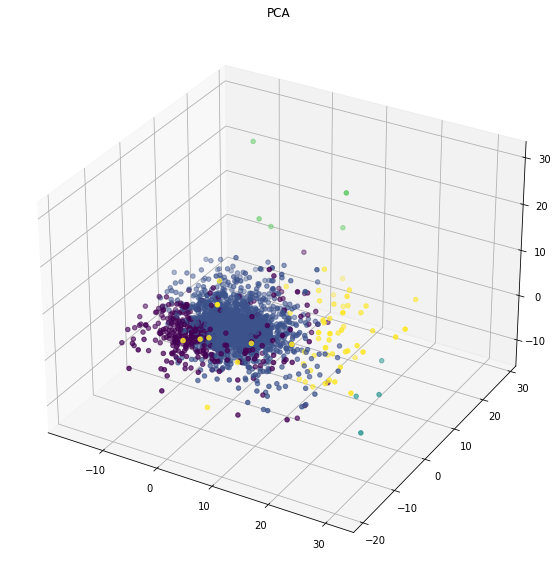

In [34]:
# PCA

fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters["PCA_3"]
x = merge_clusters["PCA_1"]
y = merge_clusters["PCA_2"]
c = merge_clusters["KM_PCA"]
ax.scatter(x, y, z, c=c)
ax.set_title('PCA')
plt.show()

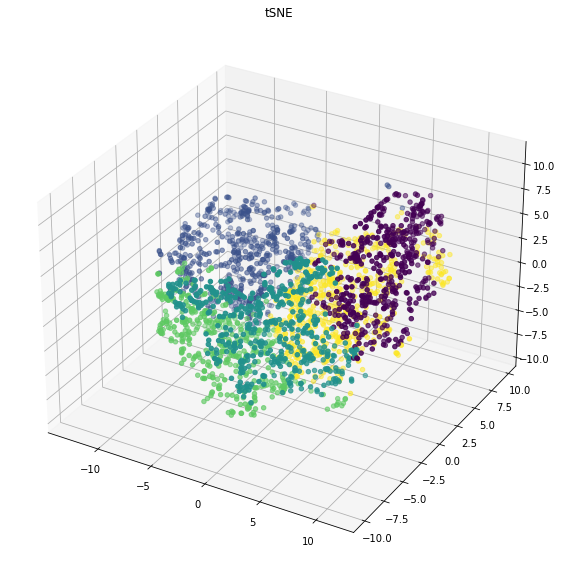

In [35]:
# TSNE
fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters["tSNE_3"]
x = merge_clusters["tSNE_1"]
y = merge_clusters["tSNE_2"]
c = merge_clusters["KM_tSNE"]
ax.scatter(x, y, z, c=c)
ax.set_title('tSNE')
plt.show()

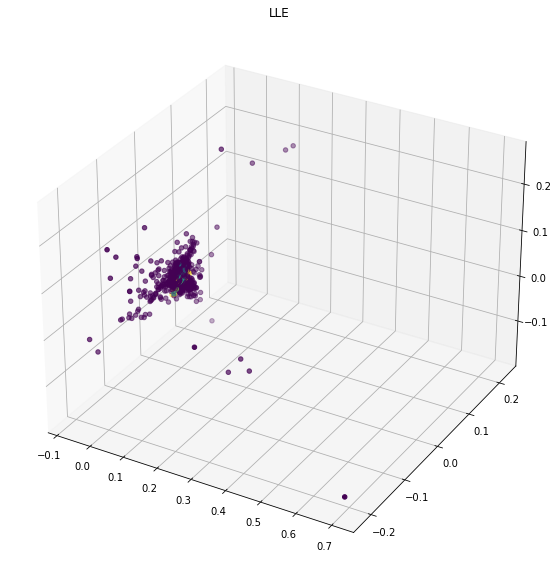

In [36]:
# LLE
fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters["LLE_3"]
x = merge_clusters["LLE_1"]
y = merge_clusters["LLE_2"]
c = merge_clusters["KM_LLE"]
ax.scatter(x, y, z, c=c)
ax.set_title('LLE')
plt.show()

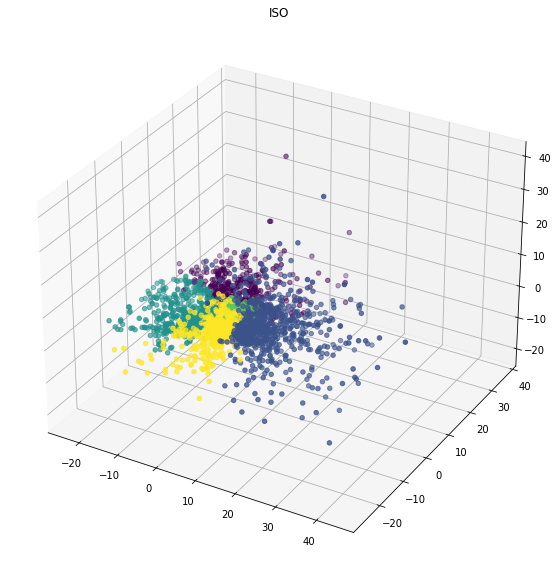

In [37]:
# ISO
fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters["ISO_3"]
x = merge_clusters["ISO_1"]
y = merge_clusters["ISO_2"]
c = merge_clusters["KM_ISO"]
ax.scatter(x, y, z, c=c)
ax.set_title('ISO')
plt.show()

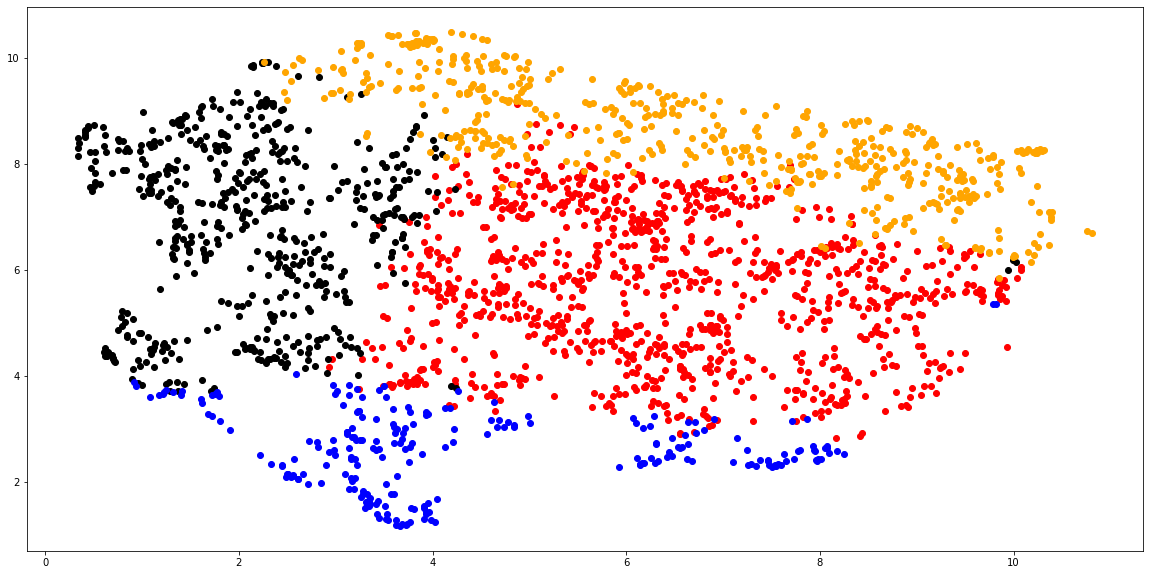

In [38]:
# UMAP
filtered_umap1 = merge_clusters[merge_clusters["KM_UMAP"] == 1]
filtered_umap2 = merge_clusters[merge_clusters["KM_UMAP"] == 2]
filtered_umap3 = merge_clusters[merge_clusters["KM_UMAP"] == 3]
filtered_umap4 = merge_clusters[merge_clusters["KM_UMAP"] == 4]
filtered_umap5 = merge_clusters[merge_clusters["KM_UMAP"] == 5]
 
#Plotting the results
plt.scatter(filtered_umap1["UMAP_1"] , filtered_umap1["UMAP_2"] , color = 'red')
plt.scatter(filtered_umap2["UMAP_1"] , filtered_umap2["UMAP_2"] , color = 'black')
plt.scatter(filtered_umap3["UMAP_1"] , filtered_umap3["UMAP_2"] , color = 'blue')
plt.scatter(filtered_umap4["UMAP_1"] , filtered_umap4["UMAP_2"] , color = 'orange')
plt.scatter(filtered_umap5["UMAP_1"] , filtered_umap5["UMAP_2"] , color = 'yellow')
plt.show()

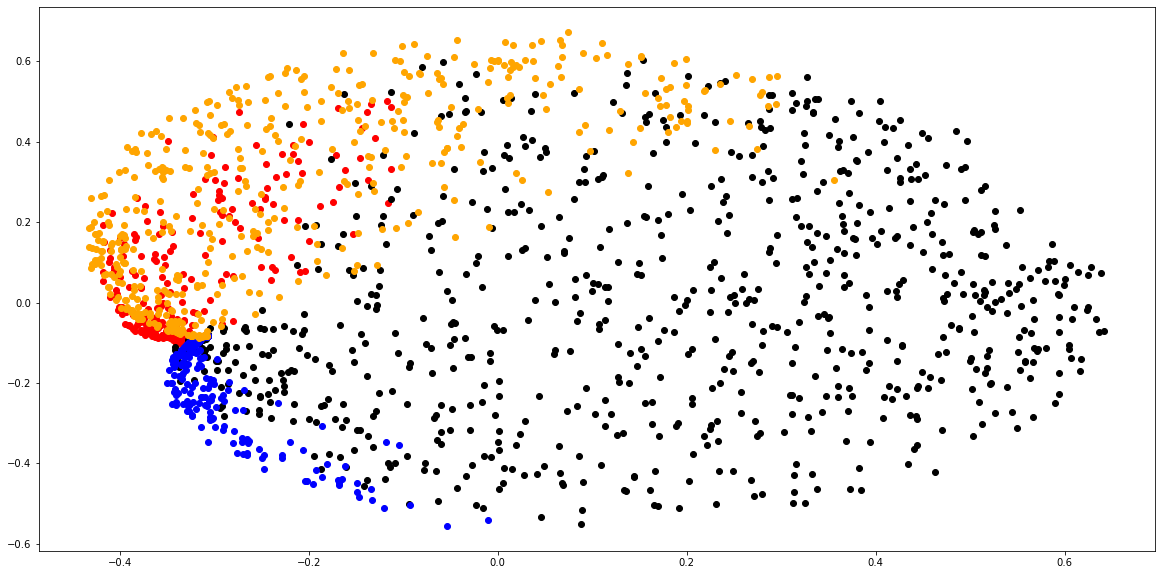

In [39]:
# KPCA
filtered_kpca1 = merge_clusters[merge_clusters["KM_KPCA"] == 1]
filtered_kpca2 = merge_clusters[merge_clusters["KM_KPCA"] == 2]
filtered_kpca3 = merge_clusters[merge_clusters["KM_KPCA"] == 3]
filtered_kpca4 = merge_clusters[merge_clusters["KM_KPCA"] == 4]
filtered_kpca5 = merge_clusters[merge_clusters["KM_KPCA"] == 5]
 
#Plotting the results
plt.scatter(filtered_kpca1["KPCA_1"] , filtered_kpca1["KPCA_2"] , color = 'red')
plt.scatter(filtered_kpca2["KPCA_1"] , filtered_kpca2["KPCA_2"] , color = 'black')
plt.scatter(filtered_kpca3["KPCA_1"] , filtered_kpca3["KPCA_2"] , color = 'blue')
plt.scatter(filtered_kpca4["KPCA_1"] , filtered_kpca4["KPCA_2"] , color = 'orange')
plt.scatter(filtered_kpca5["KPCA_1"] , filtered_kpca5["KPCA_2"] , color = 'yellow')
plt.show()

In [40]:
merge_clusters.shape

(2563, 90)

## KMeans Results

KMeans did well with the tSNE-reduced data, and not too badly with UMAP and ISO.

## DBScan Clustering

Now, we'll try DBScan clustering on the same reducers.

In [41]:
# Try DBSCAN clustering on each group of reducers
from sklearn.cluster import DBSCAN

dbscandf = pd.DataFrame()
for i,j in enumerate(all_reducers):
    dbscan = DBSCAN(eps=3, min_samples=2)
    names[i] = dbscan.fit(j).labels_
    dbscandf[i] = names[i]


# Gving column names to cluster membership columns
colnames_db = ['DB_UMAP', 'DB_LLE', 'DB_tSNE', 'DB_ISO', 'DB_PCA', 'DB_KPCA']
dbscandf.columns = colnames_db

# Merging with the original dataset
merge_clusters2 = merge_clusters.iloc[:,0:90]
merge_clusters2 = merge_clusters2.merge(dbscandf,  left_index=True, right_index=True)
merge_clusters2.head()

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,KM_KPCA,FIPS,STATE,COUNTY,DB_UMAP,DB_LLE,DB_tSNE,DB_ISO,DB_PCA,DB_KPCA
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,1,1001.0,Alabama,Autauga,0,0,0,0,0,0
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,2,1003.0,Alabama,Baldwin,0,0,0,0,0,0
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,2,1005.0,Alabama,Barbour,0,0,0,0,0,0
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,2,1007.0,Alabama,Bibb,0,0,0,0,0,0
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,2,1009.0,Alabama,Blount,0,0,0,0,0,0


## Results

These don't look too promising.  

Seems like sometimes the algorithm detected too few clusters, and sometimes too many.

In [42]:
dbscandf.value_counts()

DB_UMAP  DB_LLE  DB_tSNE  DB_ISO  DB_PCA  DB_KPCA
 0       0       0        0       0        0         2519
-1       0       0        0       0       -1           76
                                           0           18
 0       0       0        0       0       -1           18
                                           17           5
                                                     ... 
                                           11           1
                                           15           1
 3       0       0        0       0        33           1
 1       0       0        0       0        16           1
 19      0       0        0       0       -1            1
Length: 66, dtype: int64

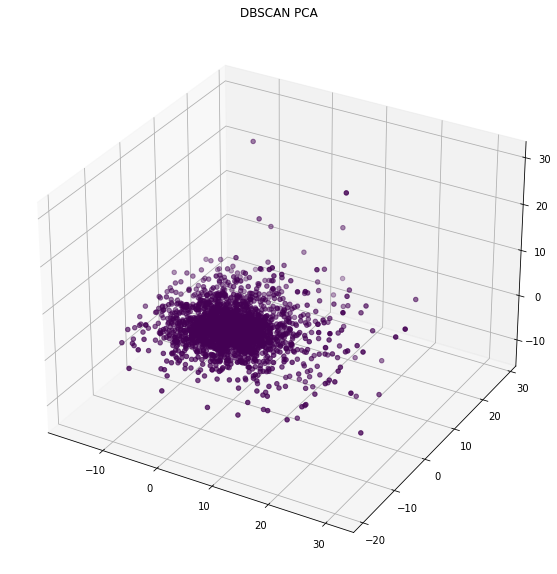

In [43]:
# PCA

fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters2["PCA_3"]
x = merge_clusters2["PCA_1"]
y = merge_clusters2["PCA_2"]
c = merge_clusters2["DB_PCA"]
ax.scatter(x, y, z, c=c)
ax.set_title('DBSCAN PCA')
plt.show()

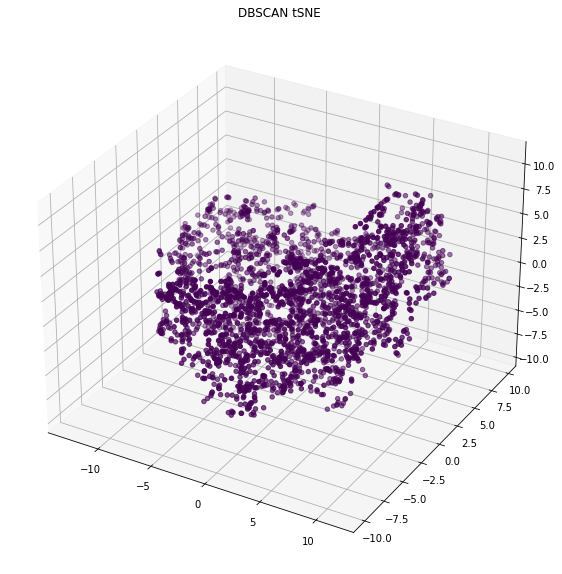

In [44]:
# TSNE
fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters2["tSNE_3"]
x = merge_clusters2["tSNE_1"]
y = merge_clusters2["tSNE_2"]
c = merge_clusters2["DB_tSNE"]
ax.scatter(x, y, z, c=c)
ax.set_title('DBSCAN tSNE')
plt.show()

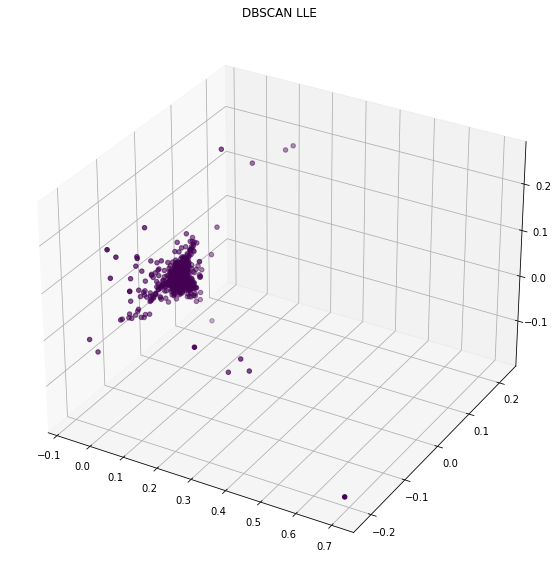

In [45]:
# LLE
fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters2["LLE_3"]
x = merge_clusters2["LLE_1"]
y = merge_clusters2["LLE_2"]
c = merge_clusters2["DB_LLE"]
ax.scatter(x, y, z, c=c)
ax.set_title('DBSCAN LLE')
plt.show()

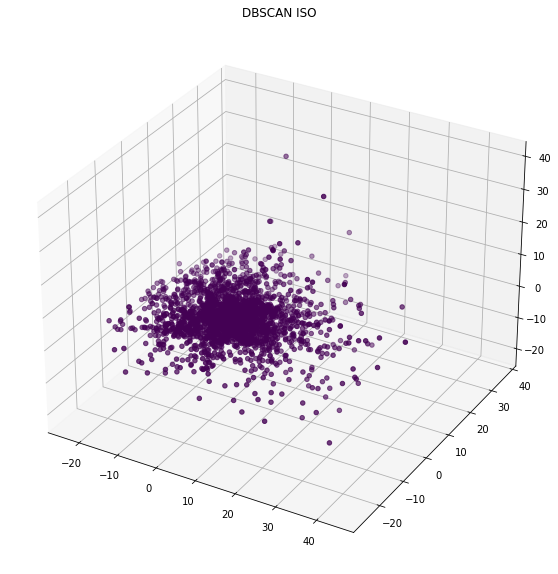

In [46]:
# ISO
fig = plt.figure()
ax = plt.axes(projection='3d')
z = merge_clusters2["ISO_3"]
x = merge_clusters2["ISO_1"]
y = merge_clusters2["ISO_2"]
c = merge_clusters2["DB_ISO"]
ax.scatter(x, y, z, c=c)
ax.set_title('DBSCAN ISO')
plt.show()

In [47]:
merge_clusters2["DB_UMAP"].value_counts()

 0     2410
-1      103
 3        4
 19       3
 2        3
 8        3
 17       3
 20       2
 4        2
 10       2
 12       2
 14       2
 16       2
 18       2
 23       2
 21       2
 1        2
 5        2
 7        2
 9        2
 11       2
 13       2
 15       2
 6        1
 22       1
Name: DB_UMAP, dtype: int64

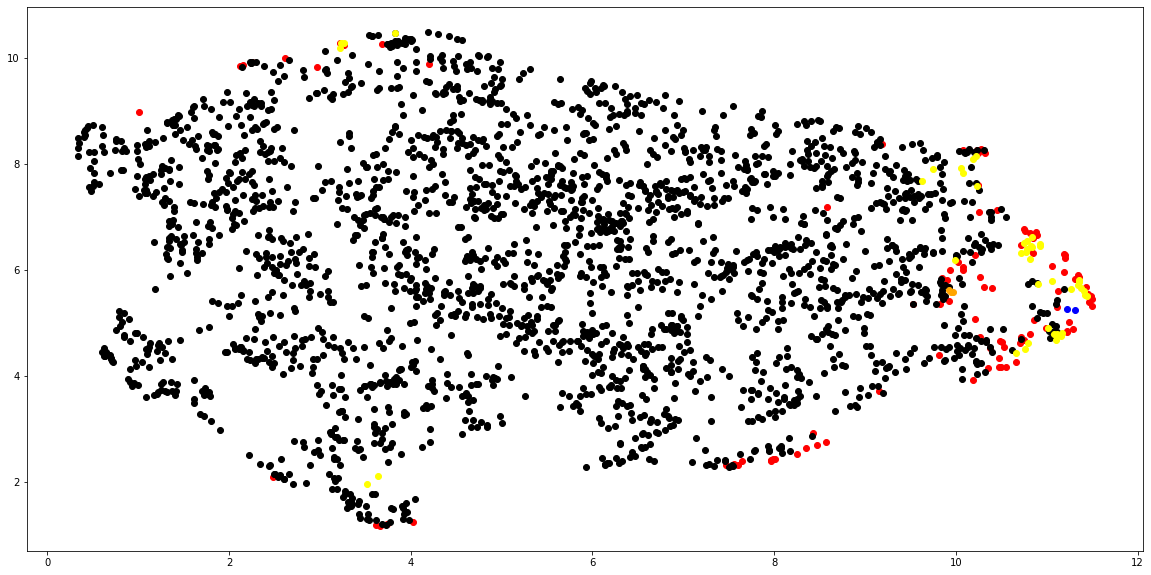

In [48]:
# UMAP
filtered_umap1 = merge_clusters2[merge_clusters2["DB_UMAP"] == -1]
filtered_umap2 = merge_clusters2[merge_clusters2["DB_UMAP"] == 0]
filtered_umap3 = merge_clusters2[merge_clusters2["DB_UMAP"] == 1]
filtered_umap4 = merge_clusters2[merge_clusters2["DB_UMAP"] == 2]
filtered_umap5 = merge_clusters2[merge_clusters2["DB_UMAP"] >= 3]
 
#Plotting the results
plt.scatter(filtered_umap1["UMAP_1"] , filtered_umap1["UMAP_2"] , color = 'red')
plt.scatter(filtered_umap2["UMAP_1"] , filtered_umap2["UMAP_2"] , color = 'black')
plt.scatter(filtered_umap3["UMAP_1"] , filtered_umap3["UMAP_2"] , color = 'blue')
plt.scatter(filtered_umap4["UMAP_1"] , filtered_umap4["UMAP_2"] , color = 'orange')
plt.scatter(filtered_umap5["UMAP_1"] , filtered_umap5["UMAP_2"] , color = 'yellow')
plt.show()

In [49]:
merge_clusters2["DB_KPCA"].value_counts()

 0     2380
-1       98
 25       5
 17       5
 4        4
 11       3
 5        3
 2        3
 22       3
 8        3
 15       3
 20       3
 18       3
 1        3
 16       2
 31       2
 14       2
 12       2
 26       2
 10       2
 6        2
 24       2
 34       2
 28       2
 30       2
 32       2
 29       2
 33       2
 3        2
 7        2
 9        2
 13       2
 21       2
 23       2
 35       2
 19       1
 27       1
Name: DB_KPCA, dtype: int64

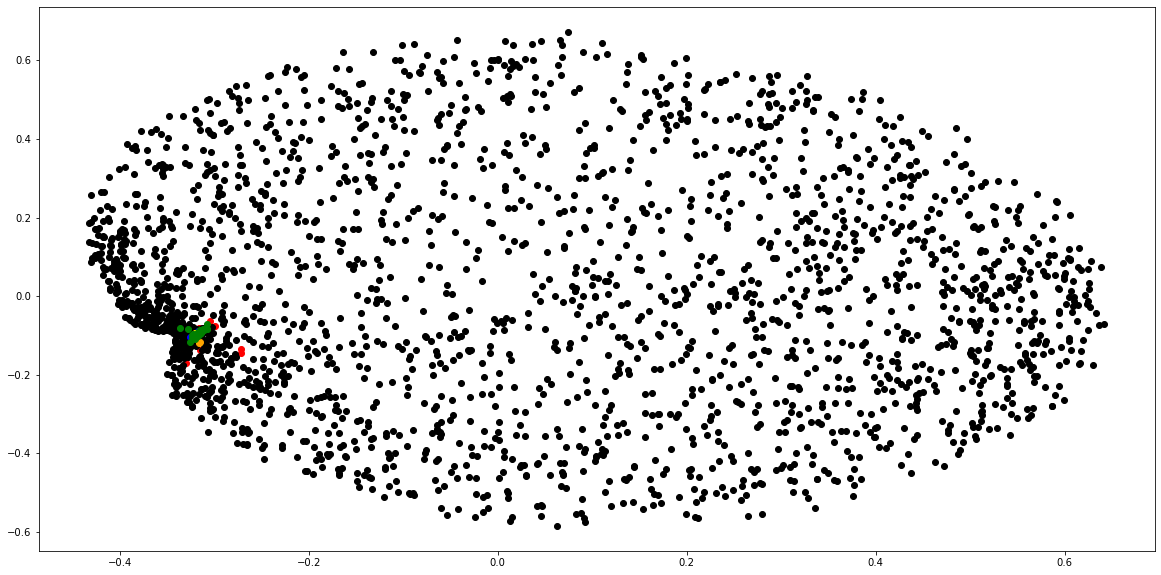

In [50]:
# KPCA
filtered_kpca1 = merge_clusters2[merge_clusters2["DB_UMAP"] == -1]
filtered_kpca2 = merge_clusters2[merge_clusters2["DB_UMAP"] == 0]
filtered_kpca3 = merge_clusters2[merge_clusters2["DB_UMAP"] == 1]
filtered_kpca4 = merge_clusters2[merge_clusters2["DB_UMAP"] == 2]
filtered_kpca5 = merge_clusters2[merge_clusters2["DB_UMAP"] == 3]
filtered_kpca6 = merge_clusters2[merge_clusters2["DB_UMAP"] > 3]

#Plotting the results
plt.scatter(filtered_kpca1["KPCA_1"] , filtered_kpca1["KPCA_2"] , color = 'red')
plt.scatter(filtered_kpca2["KPCA_1"] , filtered_kpca2["KPCA_2"] , color = 'black')
plt.scatter(filtered_kpca3["KPCA_1"] , filtered_kpca3["KPCA_2"] , color = 'blue')
plt.scatter(filtered_kpca4["KPCA_1"] , filtered_kpca4["KPCA_2"] , color = 'orange')
plt.scatter(filtered_kpca5["KPCA_1"] , filtered_kpca5["KPCA_2"] , color = 'yellow')
plt.scatter(filtered_kpca6["KPCA_1"] , filtered_kpca6["KPCA_2"] , color = 'green')
plt.show()

## DBScan Results

DBScan did poorly with all the reducer-types.

The DBScan clusters will not be retained.

The KMeans clusters will be retained, but only tSNE's clusters will be used.

In [51]:
merge_clusters.to_csv("/home/kylier/python/DS/data/PUF/PUF_RWJF_MERGED_CLUSTERED.csv")